
# Orientation-Triage Sequence Analysis

In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

from FRVRS import nu
import os
import pandas as pd

In [3]:

# Get all CSVs into one data frame
frvrs_logs_df = nu.load_data_frames(frvrs_logs_df='frvrs_logs_df')['frvrs_logs_df']
print(frvrs_logs_df.shape)

Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/frvrs_logs_df.pkl.
Argument 'placement' has incorrect type (expected pandas._libs.internals.BlockPlacement, got slice)
No pickle exists for frvrs_logs_df - attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/frvrs_logs_df.csv.
(829116, 114)


In [4]:

nu.delete_ipynb_checkpoint_folders()


## Do Orientation/Triage scenes have statistically different Orders of Responder Negotiations?

In [5]:

summary_statistics_df = nu.load_data_frames(summary_statistics_df='summary_statistics_df')['summary_statistics_df']
print(summary_statistics_df.shape)
df = summary_statistics_df.sample(4).dropna(axis='columns', how='all')
display(df.T)

Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/summary_statistics_df.pkl.
Argument 'placement' has incorrect type (expected pandas._libs.internals.BlockPlacement, got slice)
No pickle exists for summary_statistics_df - attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/summary_statistics_df.csv.
(729, 6)


,582,198,259,542
session_uuid,d1445846-942b-422f-86ae-8b2a0b6133a8,3ce991bc-a2d1-46fd-a3a4-d3611e946ed7,590bdfe9-828c-4367-a783-75ec19d7b7d0,c51a263e-fca1-4d93-929a-2c644cc441c6
scene_id,0,1,1,1
sequence_length,59,77,73,71
sequence_entropy,0.857535,0.799152,0.854907,0.886883
sequence_turbulence,53.635349,66.314556,62.838117,65.583382
sequence_complexity,0.577838,0.514653,0.521867,0.590529


In [9]:

on_columns_list = list(set(frvrs_logs_df.columns).intersection(set(summary_statistics_df.columns)))
columns_list = [
    'action_type', 'action_tick', 'event_time', 'session_uuid', 'file_name', 'logger_version',
    'scene_id', 'patient_id', 'location_id', 'is_scene_aborted', 'scene_type', 'is_a_one_triage_file',
    'sequence_length', 'sequence_entropy', 'sequence_turbulence', 'sequence_complexity'
]
summary_statistics_df = frvrs_logs_df.merge(summary_statistics_df, on=on_columns_list)[columns_list]
print(summary_statistics_df.shape)
df = summary_statistics_df.sample(4).dropna(axis='columns', how='all')
print(df.columns.tolist())
display(df.T)

(827849, 16)
['action_type', 'action_tick', 'event_time', 'session_uuid', 'file_name', 'logger_version', 'scene_id', 'patient_id', 'location_id', 'is_scene_aborted', 'scene_type', 'is_a_one_triage_file', 'sequence_length', 'sequence_entropy', 'sequence_turbulence', 'sequence_complexity']


,640742,539429,205278,573085
action_type,TOOL_SELECTED,S_A_L_T_WALKED,TOOL_HOVER,S_A_L_T_WALK_IF_CAN
action_tick,834093,221338,311086,76713
event_time,2022-03-15 11:32:00,2022-03-16 10:30:42,2023-08-03 09:57:15,2022-03-16 10:28:18
session_uuid,4ca5febe-0a4b-4c77-bd3e-6632ae760df1,26f08763-076e-4531-a6f7-f00232f664bd,f3447210-99fa-4990-8c1b-747a1e916e79,26f08763-076e-4531-a6f7-f00232f664bd
file_name,Double runs removed/22.03.15.1119r.csv,Disaster Day 2022/RM_1031.csv,DCEMS Round 2 only triage sessions/f3447210-99...,Disaster Day 2022/RM_1031.csv
logger_version,1.0,1.3,1.0,1.3
scene_id,0,0,0,0
patient_id,NaN,Helga_10 Root,NaN,Helga_10 Root
location_id,NaN,"(4.0, 0.0, -34.3)",NaN,"(3.4, 0.0, 34.3)"
is_scene_aborted,False,False,False,False


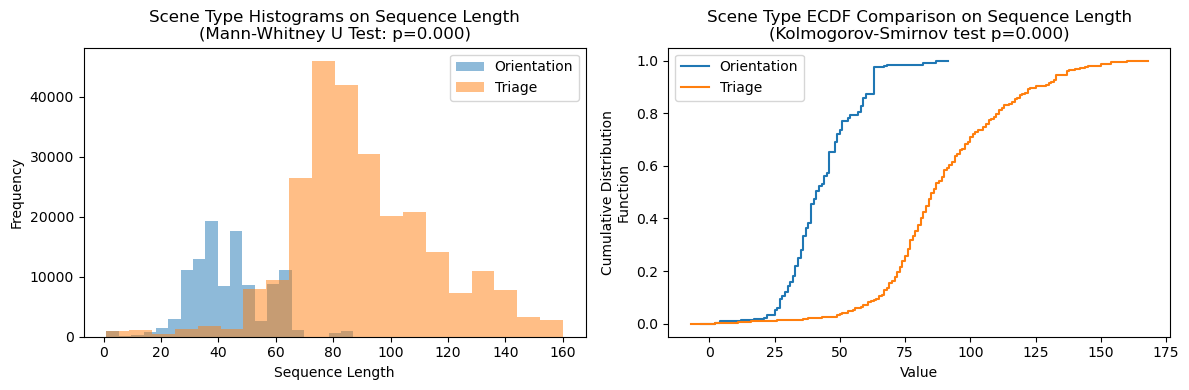

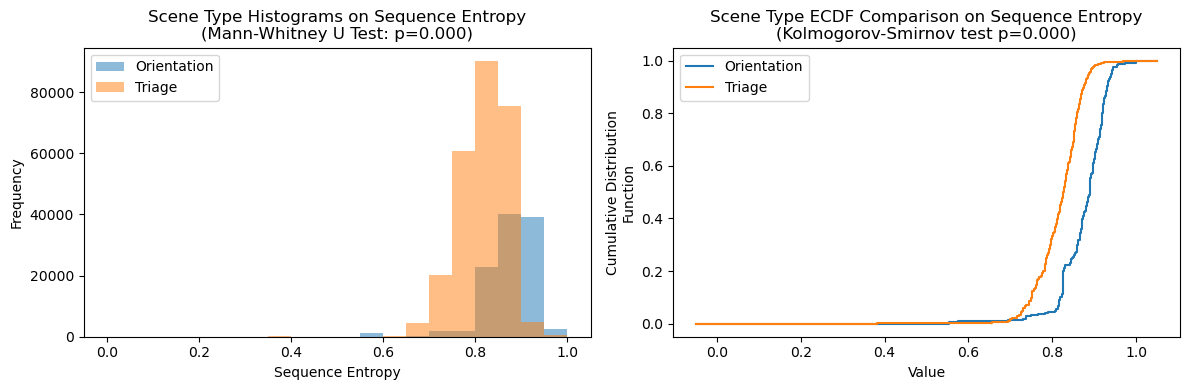

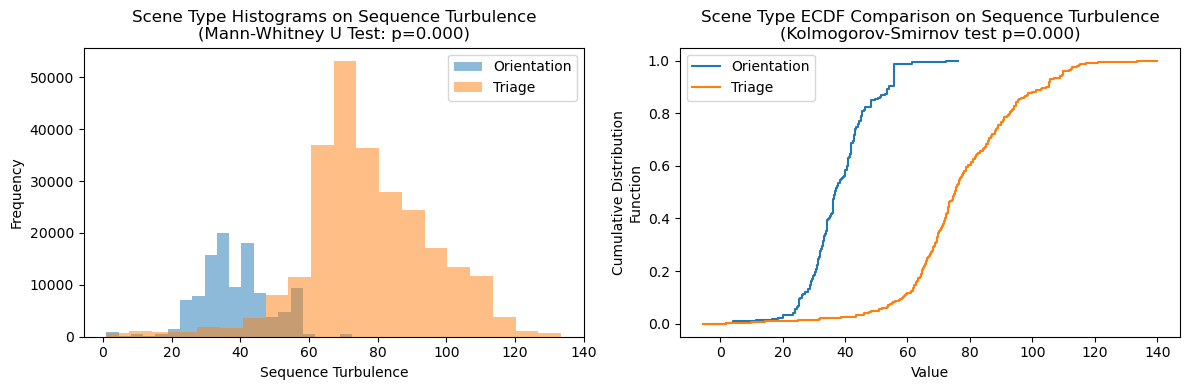

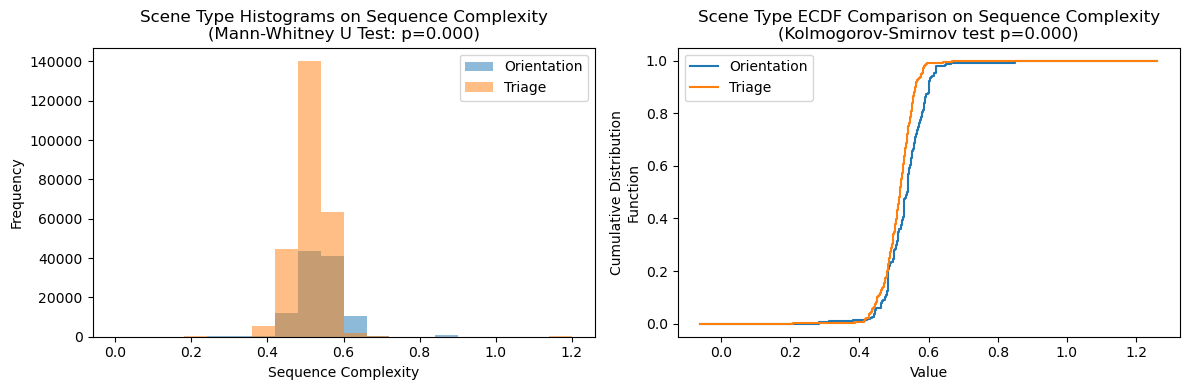

In [12]:

import matplotlib.pyplot as plt
from scipy import stats

summary_statistics_list = ['sequence_length', 'sequence_entropy', 'sequence_turbulence', 'sequence_complexity']
mask_series = summary_statistics_df.is_a_one_triage_file
gb = summary_statistics_df[mask_series].groupby('scene_type')
for summary_statistic in summary_statistics_list:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot the histograms with transparency and labels
    data_dict = {}
    for scene_type, scene_type_df in gb:
        data_array = scene_type_df[summary_statistic].values
        data_dict[scene_type] = data_array
        ax1.hist(data_array, bins=20, alpha=0.5, label=scene_type)
    
    # Perform the statistical tests
    mwu_stat, mwu_pval = stats.mannwhitneyu(data_dict['Orientation'], data_dict['Triage'])
    
    # Construct the title text with test results
    stat_title = summary_statistic.replace('_', ' ').title()
    title_text = f'Scene Type Histograms on {stat_title}'
    title_text += f'\n(Mann-Whitney U Test: p={mwu_pval:.3f})'
    
    # Set the plot title with formatted text
    ax1.set_title(title_text)
    
    # Customize the plot
    ax1.set_xlabel(stat_title)
    ax1.set_ylabel('Frequency')
    ax1.legend()  # Add legend
    
    # Perform the K-S test and calculate ECDFs
    kstest_stat, kstest_pval = stats.kstest(data_dict['Orientation'], data_dict['Triage'])
    ecdf_orientation = stats.ecdf(data_dict['Orientation'])
    ecdf_triage = stats.ecdf(data_dict['Triage'])

    # Plot ECDFs on ax2
    ecdf_orientation.cdf.plot(ax2, label='Orientation')
    ecdf_triage.cdf.plot(ax2, label='Triage')

    # Customize ECDF plot
    ax2.set_xlabel('Value')
    ax2.set_ylabel('Cumulative Distribution\nFunction')
    title_text = f'Scene Type ECDF Comparison on {stat_title}'
    title_text += f'\n(Kolmogorov-Smirnov test p={kstest_pval:.3f})'
    ax2.set_title(title_text)
    ax2.legend()

    # Adjust layout and spacing
    plt.tight_layout()


## Do files switch back and forth between the orientation and normal training?

In [14]:

# Visualize the scene type sequence in each file by looping through
# each unique file and scene combination and recording the sequence
from FRVRS import fu

time_groups_dict = {}
for file_name, file_df in frvrs_logs_df.groupby('file_name'):
    key = file_name
    actions_list = []
    for scene_id, scene_df in file_df.sort_values('scene_id').groupby('scene_id'):
        scene_type = fu.get_scene_type(scene_df)
        actions_list.append(scene_type)
    time_groups_dict[key] = actions_list
color_dict = {'Orientation': '#1f77b4', 'Triage': '#ff7f0e'}

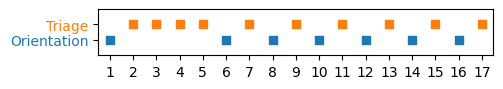

In [15]:

# Plot the time groups sequence with the greatest length
sequence = sorted(time_groups_dict.values(), key=lambda x: len(x), reverse=True)[0]
fig = nu.plot_sequence(sequence, color_dict=color_dict, verbose=False)

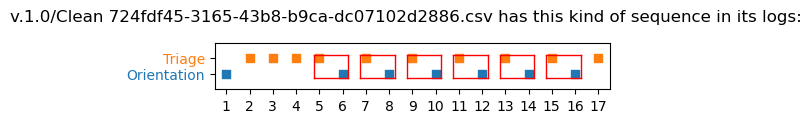

In [16]:

# Get the sequence with the highest number of ngrams
highlighted_ngrams = ['Triage', 'Orientation']
sequence = sorted(time_groups_dict.values(), key=lambda actions_list: nu.count_ngrams(actions_list, highlighted_ngrams), reverse=True)[0]
for k, v in time_groups_dict.items():
    if v == sequence: fig = nu.plot_sequence(
        sequence, highlighted_ngrams=highlighted_ngrams, suptitle=f'{k} has this kind of sequence in its logs:', color_dict=color_dict, verbose=False
    )

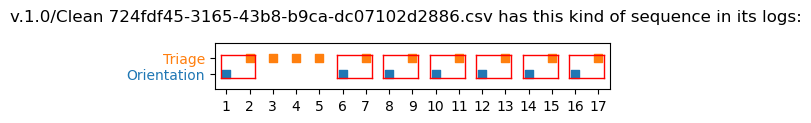

In [17]:

# Get the sequence with the highest number of ngrams
highlighted_ngrams = ['Orientation', 'Triage']
sequence = sorted(time_groups_dict.values(), key=lambda actions_list: nu.count_ngrams(actions_list, highlighted_ngrams), reverse=True)[0]
for k, v in time_groups_dict.items():
    if v == sequence: fig = nu.plot_sequence(
        sequence, highlighted_ngrams=highlighted_ngrams, suptitle=f'{k} has this kind of sequence in its logs:', color_dict=color_dict, verbose=False
    )

In [22]:

# Get 1 sequences from the time groups dictionary
sequences = nu.get_sequences_by_count(time_groups_dict, count=1)

# Plot the time group sequences side-by-side
nu.plot_sequences(sequences, color_dict=color_dict);

TypeError: NotebookUtilities.plot_sequences() got an unexpected keyword argument 'color_dict'

In [19]:

triage_count_df = pd.DataFrame([{'file_name': k, 'triage_count': v.count('Triage')} for k, v in time_groups_dict.items()])

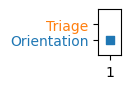

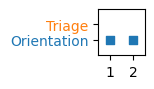

In [20]:

# Visualize the files with zero scenes
mask_series = (triage_count_df.triage_count == 0)
file_names_list = triage_count_df[mask_series].file_name.tolist()

# O(n), where n is the number of elements in the time groups dictionary
sequences_set = set([str(v) for k, v in time_groups_dict.items() if k in file_names_list])

highlighted_ngrams = ['Triage', 'Orientation']

# O(n log n), where n is the number of elements in the sequences set
for sequence in sorted([eval(s) for s in sequences_set]): fig = nu.plot_sequence(
    sequence, highlighted_ngrams=highlighted_ngrams, suptitle=None, color_dict=color_dict, verbose=False
)

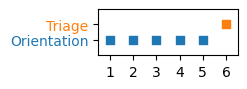

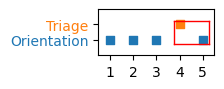

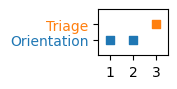

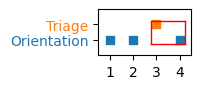

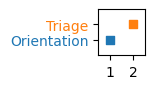

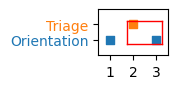

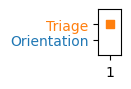

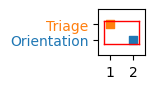

In [21]:

# Visualize the files with one scene
mask_series = (triage_count_df.triage_count == 1)
file_names_list = triage_count_df[mask_series].file_name.tolist()

# O(n), where n is the number of elements in the time groups dictionary
sequences_set = set([str(v) for k, v in time_groups_dict.items() if k in file_names_list])

highlighted_ngrams = ['Triage', 'Orientation']

# O(n log n), where n is the number of elements in the sequences set
for sequence in sorted([eval(s) for s in sequences_set]): fig = nu.plot_sequence(
    sequence, highlighted_ngrams=highlighted_ngrams, suptitle=None, color_dict=color_dict, verbose=False
)

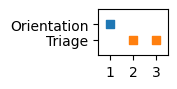

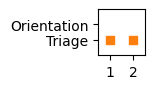

In [11]:

# Visualize the files with two scenes
triage_count_df = pd.DataFrame([{'file_name': k, 'triage_count': v.count('Triage')} for k, v in time_groups_dict.items()])
mask_series = (triage_count_df.triage_count == 2)
file_names_list = triage_count_df[mask_series].file_name.tolist()

# O(n), where n is the number of elements in the time groups dictionary
sequences_set = set([str(v) for k, v in time_groups_dict.items() if k in file_names_list])

highlighted_ngrams = ['Triage', 'Orientation']

# O(n log n), where n is the number of elements in the sequences set
for sequence in sorted([eval(s) for s in sequences_set]): fig = nu.plot_sequence(
    sequence, highlighted_ngrams=highlighted_ngrams, suptitle=None, color_dict=color_dict, verbose=False
)